# Quality Control

<!--NAVIGATION-->
< [Pre-alignment Workflow](01.00-prealn-wf.ipynb) | [Contents](Index.ipynb) | [Merging SRXs](01.02-prealn-wf_merge_srr.ipynb) >

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs
from ncbi_remap.io import add_table

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_qc')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../sra.h5')

last updated: 2017-12-21 
Git hash: 1b967a52a83923ec9a93b57db9d3dee8b476e63f


In [2]:
# Constants
from ncbi_remap.prealn_wf import (LIBSIZE_CUTOFF, READLEN_CUTOFF, STRAND_CUTOFF1, 
    STRAND_CUTOFF2, UNALIGN_CUTOFF, CONTAMINATION_CUTOFF)

REFERENCES = [
    'adapters', 
    'phix', 
    'ercc', 
    'dm6', 
    'wolbachia', 
    'yeast', 
    'ecoli', 
    'hg19',
]

num_samples = store['prealn/flags'].flag_complete.sum()

First I asses run quality. SRA accepts any type of sequencing data including data from low throughput methods. Here I want to focus only on high throughput sequencing experiments, therefore these quality control metrics may identify low throughput methods as low quality. Sequencing quality has also improved over the last 10 years, which may cause older experiments may also fail quality metrics. It is also possible that author's or sequencing centers may include lower quality datasets for completeness.

## Library Size

Library size is the number of reads obtained from a sequencing run. Over the past decade sequencing technologies have increased library size dramatically. For example, typical library sizes for the Illumina GAIIx was ~42 mil reads per lane, while the more recent HiSeq X can produce 375 mil reads per lane. However, multiplexing has also become more feasible, splitting reads across multiple samples that have been mixed together. Here we focus on libraries that have at least {{'{:,.0f}'.format(LIBSIZE_CUTOFF)}} reads. Note: during the download process I consider a sample failing download if its library size ≤1,000 reads.

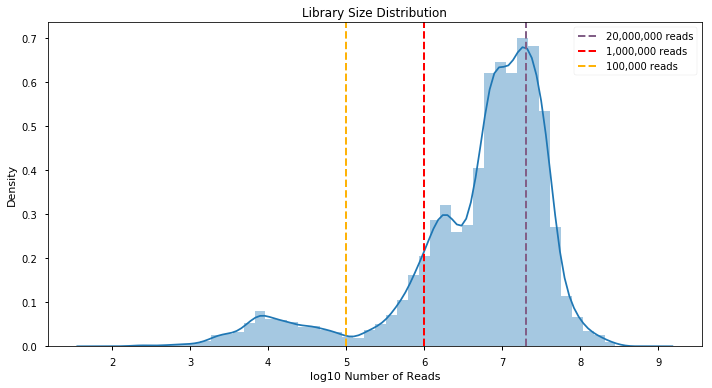

In [3]:
# Plot distribution of libsizes
@make_figs(nbconfig.fig_name('distplot_libsize'), 
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    sr = store['prealn/workflow/fastq']['libsize_R1']
    fig, ax = plt.subplots(1, 1)
    sns.distplot(np.log10(sr), ax=ax)
    ax.axvline(np.log10(2e7), ls='--', lw=2, color=sns.xkcd_rgb['dusty purple'], label='20,000,000 reads')
    ax.axvline(np.log10(1e6), ls='--', lw=2, color='r', label='1,000,000 reads')
    ax.axvline(np.log10(1e5), ls='--', lw=2, color=sns.xkcd_rgb['amber'], label='100,000 reads')
    ax.legend()
    ax.set_xlabel('log10 Number of Reads')
    ax.set_ylabel('Density')
    ax.set_title('Library Size Distribution');
    return fig

plot(store)

In [5]:
# Make flags
from ncbi_remap.prealn_wf import libsize, libsize_cnts
libsize_ok = libsize(store, cutoff=LIBSIZE_CUTOFF)
libsize_million = libsize(store, cutoff=1e6)

# Summary
n_samples = '{:,}'.format(num_samples)
n_gt_million = '{:,}'.format(libsize_million.shape[0])
n_gt_ok = '{:,}'.format(libsize_ok.shape[0])
cutoff = '{:,.0f}'.format(LIBSIZE_CUTOFF)
lmin, lmed, lmax = ['{:,.0f}'.format(x) for x in libsize_cnts(store)]

Of the {{n_samples}} runs, {{n_gt_million}} runs have more than 1 million reads. The median coverage was {{lmed}} reads with most runs having less than 20 million reads. For the remainder of this project we will focus on the {{n_gt_ok}} runs that have ≥{{cutoff}} reads.

### Criteria
* Library Size ≥{{cutoff}} reads

### Summary

Library Size | Number of Reads
------------ | ---------------
Min | {{lmin}}
Median | {{lmed}}
Max | {{lmax}}
**Runs ≥{{cutoff}}** | {{n_gt_ok}} (SRRs)

## Read Length

Similar to library size, read lengths have also increased over the past decade. Early Illumina read lengths were ~30 bp long, while recent read lengths can be over 150 bp. However, the extra cost associated with extra read length are not always justified, so many labs still sequence using shorter read lengths. Note: during the download process I consider a sample failing download if its average read length was ≤10 bp. 

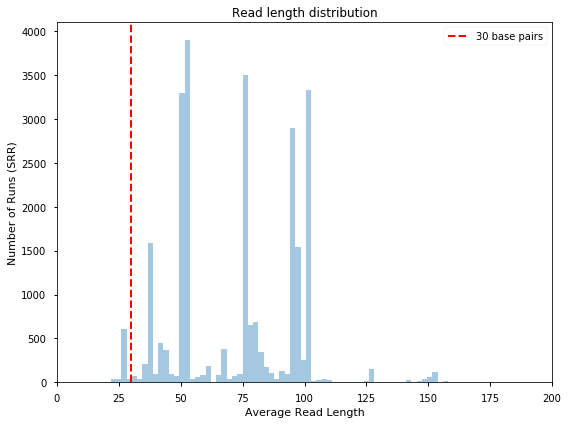

In [6]:
# Plot distirubtion of read lengths
@make_figs(nbconfig.fig_name('distplot_readLen'), 
           styles=nbconfig.styles, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq'][['avgLen_R1', 'avgLen_R2']]
    df['len'] = df[['avgLen_R1', 'avgLen_R2']].max(axis=1)

    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.len, bins=500, ax=ax, kde=False, hist_kws={"align": 'right'})
    ax.set_xlabel('Average Read Length')
    ax.set_ylabel('Number of Runs (SRR)')
    ax.set_xlim(0, 200)
    ax.set_title('Read length distribution');
    ax.axvline(READLEN_CUTOFF, ls='--', lw=2, color='r', label='{} base pairs'.format(READLEN_CUTOFF))
    ax.legend()
    
    return fig

plot(store)

In [7]:
# Make flags
from ncbi_remap.prealn_wf import readlen, readlen_cnts
readlen_ok = readlen(store, cutoff=READLEN_CUTOFF)
readlen_gt_200 = readlen(store, cutoff=200)

# Summary
cutoff = '{:.0f}'.format(READLEN_CUTOFF)
n_gt_cutoff = '{:,}'.format(readlen_ok.shape[0])
n_gt_200 = '{:,}'.format(readlen_gt_200.shape[0])

lmin, lmed, lmode, lmax = ['{:,.0f}'.format(x) for x in readlen_cnts(store)]

There are {{n_gt_cutoff}} runs that have an average read length ≥{{cutoff}} bp. Looking at the distribution of read lengths, {{lmode}} bp is the most popular read length with more than >3,500 runs, followed by 76 bp with more than 3,000 runs. There are {{n_gt_200}} runs with a read length ≥200 bp.

### Criteria
* ≥{{cutoff}} bp

### Summary

Avg Read Length | Read Length
--------------- | --------------
Min | {{lmin}}
Median | {{lmed}}
Max | {{lmax}}
**Runs ≥{{cutoff}} bp** | {{n_gt_cutoff}} (SRRs)

## Stranded

Strandedness is determined by the library construction protocol, with the majority of samples likely to be from an unstranded protocol, followed by second stranded (e.g. Illumina's stranded protocol). Library strandedness is an important metric to decide which runs are useful for different purposes (e.g., annotation or splicing). Strandedness is also used as common alignment and coverage count parameter.

To determine strandedness, reads were aligned in unstranded mode with hisat2. Alignments were then processed with Picard's CollectRNASeqMetrics using three separate modes (First stranded, Second stranded, Unstranded). In First stranded mode, reads are expected to map to the same strand as the gene model. In Second stranded mode, reads are expected to map to the opposite strand. Finally in unstranded mode reads are expected to map equally to both strands. Picard reports the proportion of reads that map to the "correct" strand. We use this proportion as a metric for strandedness. While not strictly a quality control metric, if a stranded protocol was attempted, incomplete strandedness could indicate potential problems during library preparation.

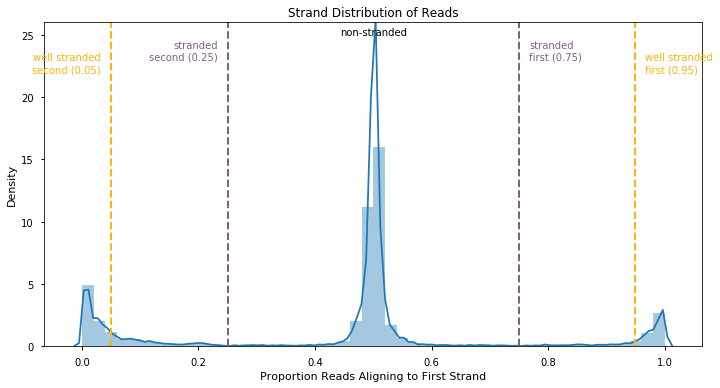

In [8]:
# Plot distribution of strandedness
@make_figs(nbconfig.fig_name('distplot_strandedness'), styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/collectrnaseqmetrics/first']
    c1 = sns.xkcd_rgb['dusty purple']
    c2 = sns.xkcd_rgb['amber']
    
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.PCT_CORRECT_STRAND_READS, ax=ax)
    ax.set_title('Strand Distribution of Reads')
    ax.set_xlabel('Proportion Reads Aligning to First Strand')
    ax.set_ylabel('Density')
    ax.axvline(STRAND_CUTOFF1, ls='--', lw=2, color=c1)
    ax.axvline(1 - STRAND_CUTOFF1, ls='--', lw=2, color=c1)
    ax.axvline(STRAND_CUTOFF2, ls='--', lw=2, color=c2)
    ax.axvline(1 - STRAND_CUTOFF2, ls='--', lw=2, color=c2)

    _ct1 = STRAND_CUTOFF1
    _ct2 = 1 - STRAND_CUTOFF1
    ax.annotate(xy=(_ct1, 23), s='stranded\nfirst ({:.2f})'.format(_ct1), xytext=(10, 0), textcoords='offset points', color=c1)
    ax.annotate(xy=(_ct2, 23), s='stranded\nsecond ({:.2f})'.format(_ct2), ha='right', xytext=(-10, 0), textcoords='offset points', color=c1)

    _ct1 = STRAND_CUTOFF2
    _ct2 = 1 - STRAND_CUTOFF2
    ax.annotate(xy=(_ct1, 22), s='well stranded\nfirst ({:.2f})'.format(_ct1), xytext=(10, 0), textcoords='offset points', color=c2)
    ax.annotate(xy=(_ct2, 22), s='well stranded\nsecond ({:.2f})'.format(_ct2), ha='right', xytext=(-10, 0), textcoords='offset points', color=c2)

    ax.annotate(xy=(.5, 25), s='non-stranded', ha='center', color='k')
    ax.set_ylim(0, 26)
    return fig

plot(store)

In [9]:
# Make flags
from ncbi_remap.prealn_wf import strandedness

def pout(c, f, s, u):
    print("""\
    Cutoff: {:0.2f}
    First Strand: {:,}
    Second Strand: {:,}
    Unstranded: {:,}
    """.format(c, f.shape[0], s.shape[0], u.shape[0]))

f1, s1, u1 = strandedness(store, cutoff=STRAND_CUTOFF1)
f2, s2, u2 = strandedness(store, cutoff=STRAND_CUTOFF2)


# Summary
cutoff1 = '{:.2f}'.format(STRAND_CUTOFF1)
cutoff2 = '{:.2f}'.format(STRAND_CUTOFF2)

n_f_cutoff1 = '{:,}'.format(f1.shape[0])
n_s_cutoff1 = '{:,}'.format(s1.shape[0])
n_u_cutoff1 = '{:,}'.format(u1.shape[0])

n_f_cutoff2 = '{:,}'.format(f2.shape[0])
n_s_cutoff2 = '{:,}'.format(s2.shape[0])
n_u_cutoff2 = '{:,}'.format(u2.shape[0])

For First stranded mode, we look at the proportion of reads aligning to correct strand (PCT_CORRECT_STRAND_READS). Unstranded runs have approximately 50% of reads mapping to the first strand. First stranded runs have the majority of reads mapping to the correct strand. Second stranded runs have few reads mapping to the first strand. Here we selected two cutoffs ({{cutoff1}}, {{cutoff2}}). For setting alignment criteria we used less stringent {{cutoff1}}. While {{cutoff2}} are well stranded runs that would be more appropriate for looking annotations. 

### Criteria
* ≥{{cutoff1}} reads correct strand
* ≥{{cutoff2}} reads correct strand

### Summary

**≥{{cutoff1}} reads correct strand**

Strandedness | Number of Runs
------------ | --------------
First Strand | {{n_f_cutoff1}}
Second Strand | {{n_s_cutoff1}}
Unstranded | {{n_u_cutoff1}}


**≥{{cutoff2}} reads correct strand**

Strandedness | Number of Runs
------------ | --------------
First Strand | {{n_f_cutoff2}}
Second Strand | {{n_s_cutoff2}}
Unstranded | {{n_u_cutoff2}}



## Mappability

Next we look at how well the reads align to the reference genome (FlyBase r6.11). Here we look at overall mappability. Independent of the library strategy, we may expect that the majority of reads should map to the reference genome. A large fraction of unaligned reads indicate either issues with library construction or an incorrect reference genome. There are known instances where libraries were constructed by mixing multiple species, but these are rare and in our experience species specific reads are separated prior to upload. Therefore we look to exclude runs that have excessive amounts of unaligned reads.

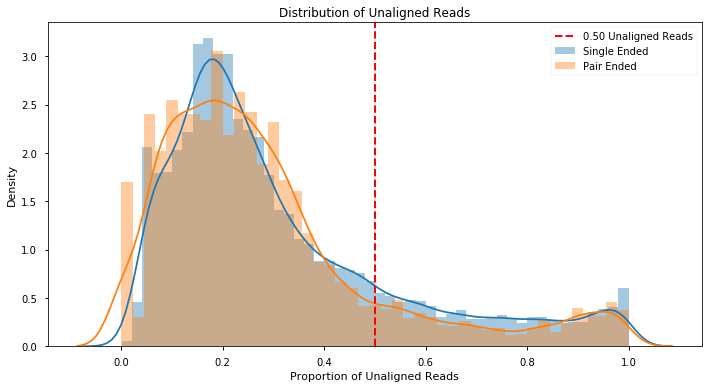

In [10]:
# Plot distribution of unmapped reads.
@make_figs(nbconfig.fig_name('distplot_unaligned'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    se = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_unpaired', 'num_unaligned']].copy()
    se.dropna(inplace=True)
    se['prop_unaligned'] = se['num_unaligned'] / se['num_reads']

    pe = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_paired', 'num_concordant_reads_unaligned']].copy()
    pe.dropna(inplace=True)
    pe['prop_unaligned'] = pe['num_concordant_reads_unaligned'] / pe['num_reads']

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.prop_unaligned, ax=ax, label='Single Ended')
    sns.distplot(pe.prop_unaligned, ax=ax, label='Pair Ended')
    ax.axvline(UNALIGN_CUTOFF, color='r', ls='--', lw=2, label='{:0.2f} Unaligned Reads'.format(UNALIGN_CUTOFF))
    ax.legend()
    ax.set_title('Distribution of Unaligned Reads')
    ax.set_xlabel('Proportion of Unaligned Reads')
    ax.set_ylabel('Density');
    
plot(store)

In [11]:
# Make flags
from ncbi_remap.prealn_wf import mappability
mapping_ok = mappability(store, cutoff=UNALIGN_CUTOFF)

# Summary
cutoff = '{:.0f}'.format(UNALIGN_CUTOFF * 100)
n_lt_cutoff = '{:,.0f}'.format(mapping_ok.shape[0])

The majority of runs (n={{n_lt_cutoff}}) had less than {{cutoff}}% of reads unaligned. Single-End and Pair-End runs show similar distributions of unaligned reads.  

## Contamination

In any experiment there is always a chance for contamination. Typically we know potential sources of contamination. However, when dealing with public data it is impossible to know these details. To get a better understanding on potential problems we mapped a subset of reads to different references. These references include technical references that would be introduced on purpose (adapters, ERCC, phiX controls), and biological references that may or may not have been introduced on purpose (yeast, wolbachia, ecoli, and human). We expect that the majority of reads should map preferentially to the Drosophila reference (dm6), and excessive amounts of mapping to another reference my indicate contamination or improper library construction. Reads were summarized into different classes based on if reads align to a single or multiple locations within a references and if they align to a single or multiple references. 

### One Hit One Reference

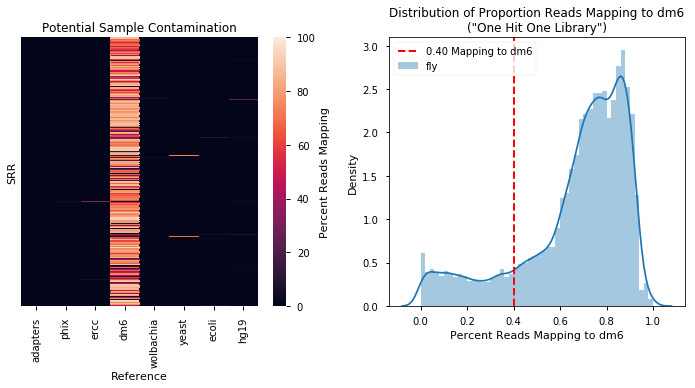

In [12]:
# Plot heatmap of one hit one species
@make_figs(nbconfig.fig_name('heatmap_distplot_contamination'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq_screen'].copy()
    df.reset_index(inplace=True)
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).unstack()
    df.columns = df.columns.droplevel(0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.heatmap(df[REFERENCES], yticklabels=False, cbar_kws={'label': 'Percent Reads Mapping'}, ax=ax1)
    ax1.set_title('Potential Sample Contamination');
    ax1.set_ylabel('SRR');
    ax1.set_xlabel('Reference');

    # Plot distirbution of major categories
    sns.distplot(df.dm6 / 100, label='fly', ax=ax2)
    plt.title('Distribution of Proportion Reads Mapping to dm6\n("One Hit One Library")');
    ax2.set_xlabel('Percent Reads Mapping to dm6')
    ax2.set_ylabel('Density')
    ax2.axvline(CONTAMINATION_CUTOFF / 100, color='r', ls='--', lw=2, 
                label='{:0.2f} Mapping to dm6'.format(CONTAMINATION_CUTOFF / 100))
    ax2.legend()
    
    return fig

plot(store)

In [13]:
# Create summary table showing the number of samples whose majority of 
# reads came from a specific reference.
def summary(store):
    df = store['prealn/workflow/fastq_screen'].copy()
    df.reset_index(inplace=True)
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).unstack()
    df.columns = df.columns.droplevel(0)

    table = df.apply(lambda x: x.argmax(), axis=1).value_counts()
    table['total'] = table.sum()
    table = table.map(lambda x: '{:,}'.format(x)).to_frame()

    table.columns = ['Number of Samples']
    
    return table.drop('rRNA')

df = summary(store)

/data/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


Here I focus on reads that mapped to one location in one reference, and look at which reference had the majority of reads mapping to it. There were {{df.loc['dm6', 'Number of Samples']}} samples where the Drosophila reference (dm6) had the majority of mapped reads. This was followed by {{df.loc['yeast', 'Number of Samples']}} samples were the yeast reference had majority of mapped reads. 

{{df}}

In [14]:
# Make flags
from ncbi_remap.prealn_wf import contamination
contamination_ok = contamination(store, cutoff=CONTAMINATION_CUTOFF)

# Summary
cutoff = '{:.0f}'.format(CONTAMINATION_CUTOFF)
n_gt_cutoff = '{:,.0f}'.format(contamination_ok.shape[0])

If I am a little more stringent in my cutoff criteria, and require at least {{cutoff}}% of reads map to the Drosophila reference, I have {{n_gt_cutoff}} samples. The remaining samples either had a large number of unaligned reads, a large number of reads mapping to multiple locations, or a large number of reads mapping to other references. While some "contamination" may not affect downstream analysis, having almost half of reads going somewhere else is problematic.

## QC Flags

In [16]:
# Combine all flags and save to store
ok_samples = libsize_ok.merge(
    readlen_ok, on=['srx', 'srr'], how='inner').merge(
    mapping_ok, on=['srx', 'srr'], how='inner').merge(
    contamination_ok, on=['srx', 'srr'], how='inner')

# Add to store
flags = store['prealn/flags']
flags['flag_qc_passed'] = False
flags.loc[ok_samples.set_index(['srx', 'srr']).index, 'flag_qc_passed'] = True
store['prealn/flags'] = flags

n_qc_pass =  '{:,}'.format(ok_samples.shape[0])

There are {{n_qc_pass}} samples that passed all set QC critiera. 

In [ ]:
store.close()